In [1]:
import sys
import pandas as pd
sys.path.append('../') 
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary functions
from src.loader import load_data
from src.utils import calculate_total_usage,calculate_average_usage,aggregate_user_data
from src.clean import clean_data
# Load data
# Define the correct SQL query
sql_query =  """
SELECT * FROM xdr_data;
"""
df = load_data(sql_query)


In [2]:
# apply the cleaning function
df = clean_data(df)


In [3]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [4]:
# Create a new column for Total Traffic which is the sum of upload and download traffic
df['Total Traffic (Bytes)'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

# After creating the column, you can proceed with the aggregation per customer ID (MSISDN)
aggregated_metrics = df.groupby('MSISDN/Number').agg({
    'Bearer Id': 'count',
    'Dur. (ms)': 'sum',
    'Total Traffic (Bytes)': 'sum'
}).rename(columns={
    'Bearer Id': 'Sessions Frequency',
    'Dur. (ms)': 'Total Duration (ms)',
    'Total Traffic (Bytes)': 'Total Traffic (Bytes)'
})

# Now, you can continue with identifying the top 10 customers per engagement metric.
top_10_sessions = aggregated_metrics['Sessions Frequency'].nlargest(10)
top_10_duration = aggregated_metrics['Total Duration (ms)'].nlargest(10)
top_10_traffic = aggregated_metrics['Total Traffic (Bytes)'].nlargest(10)


In [5]:

# For K-means clustering, normalize the metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalize the metrics
scaler = StandardScaler()
scaled_features = scaler.fit_transform(aggregated_metrics[['Sessions Frequency', 'Total Duration (ms)', 'Total Traffic (Bytes)']])

# Apply k-means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Assign the cluster labels to your original data
aggregated_metrics['Cluster'] = clusters



In [6]:
# Compute minimum, maximum, average, and total metrics for each cluster
cluster_metrics = aggregated_metrics.groupby('Cluster').agg({
    'Sessions Frequency': ['min', 'max', 'mean', 'sum'],
    'Total Duration (ms)': ['min', 'max', 'mean', 'sum'],
    'Total Traffic (Bytes)': ['min', 'max', 'mean', 'sum']
})


In [7]:
# Calculate the total data usage for each application by summing the download and upload data
df['Total Social Media (Bytes)'] = df['Social Media DL (Bytes)'] + df['Social Media UL (Bytes)']
df['Total Google (Bytes)'] = df['Google DL (Bytes)'] + df['Google UL (Bytes)']
df['Total Email (Bytes)'] = df['Email DL (Bytes)'] + df['Email UL (Bytes)']
df['Total Youtube (Bytes)'] = df['Youtube DL (Bytes)'] + df['Youtube UL (Bytes)']
df['Total Netflix (Bytes)'] = df['Netflix DL (Bytes)'] + df['Netflix UL (Bytes)']
df['Total Gaming (Bytes)'] = df['Gaming DL (Bytes)'] + df['Gaming UL (Bytes)']
df['Total Other (Bytes)'] = df['Other DL (Bytes)'] + df['Other UL (Bytes)']

# Now, aggregate this data per user (MSISDN/Number)
aggregated_per_user_app = df.groupby('MSISDN/Number').agg({
    'Total Social Media (Bytes)': 'sum',
    'Total Google (Bytes)': 'sum',
    'Total Email (Bytes)': 'sum',
    'Total Youtube (Bytes)': 'sum',
    'Total Netflix (Bytes)': 'sum',
    'Total Gaming (Bytes)': 'sum',
    'Total Other (Bytes)': 'sum'
}).reset_index()

# Derive the top 10 most engaged users per application
top_users_per_app = {
    'Social Media': aggregated_per_user_app.nlargest(10, 'Total Social Media (Bytes)'),
    'Google': aggregated_per_user_app.nlargest(10, 'Total Google (Bytes)'),
    'Email': aggregated_per_user_app.nlargest(10, 'Total Email (Bytes)'),
    'Youtube': aggregated_per_user_app.nlargest(10, 'Total Youtube (Bytes)'),
    'Netflix': aggregated_per_user_app.nlargest(10, 'Total Netflix (Bytes)'),
    'Gaming': aggregated_per_user_app.nlargest(10, 'Total Gaming (Bytes)'),
    'Other': aggregated_per_user_app.nlargest(10, 'Total Other (Bytes)')
}


In [8]:
top_users_per_app

{'Social Media':         MSISDN/Number  Total Social Media (Bytes)  Total Google (Bytes)  \
 13526    3.362632e+10                  43374779.0           152191852.0   
 92923    3.376054e+10                  39783189.0           123223099.0   
 37052    3.365973e+10                  35412358.0           116516345.0   
 6437     3.361489e+10                  28294544.0           127973787.0   
 13180    3.362578e+10                  27135500.0           142307915.0   
 65118    3.366716e+10                  24247850.0           105032696.0   
 106137   3.378632e+10                  23974919.0           110254484.0   
 70960    3.366907e+10                  23800834.0            77824684.0   
 666      3.360313e+10                  23077825.0            86929016.0   
 31331    3.365849e+10                  23000066.0            76434143.0   
 
         Total Email (Bytes)  Total Youtube (Bytes)  Total Netflix (Bytes)  \
 13526            42418782.0            374483047.0            32872

In [9]:
# Sum up the total usage for each application across all users
total_traffic_per_app = aggregated_per_user_app[['Total Social Media (Bytes)', 'Total Google (Bytes)',
                                                 'Total Email (Bytes)', 'Total Youtube (Bytes)',
                                                 'Total Netflix (Bytes)', 'Total Gaming (Bytes)',
                                                 'Total Other (Bytes)']].sum().sort_values(ascending=False)


In [10]:
# Get the top 3 most used applications
top_3_apps = total_traffic_per_app.head(3)
top_3_app_names = top_3_apps.index.tolist()


/tmp/ipykernel_19946/1136807218.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_3_apps_sorted.values, y=top_3_apps_sorted.index, palette=colors)


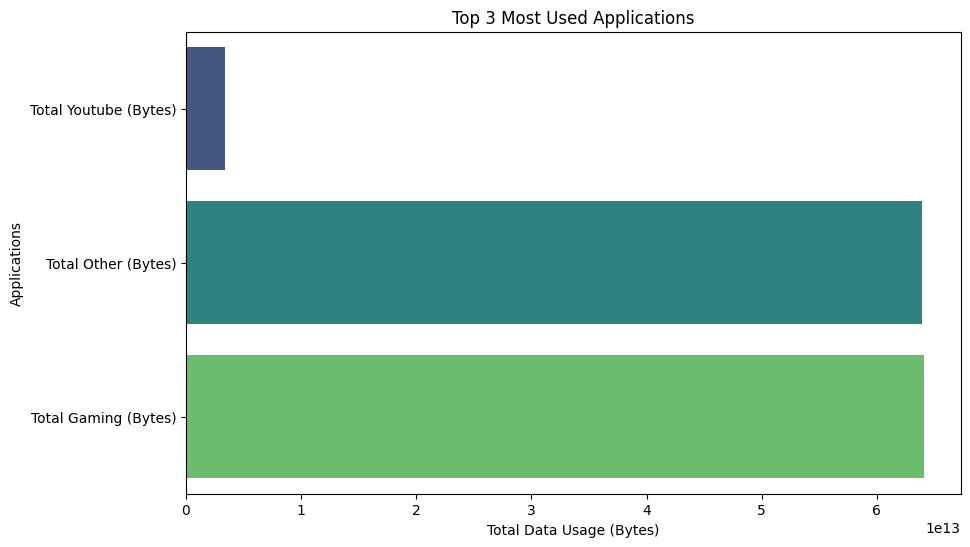

In [11]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette('viridis', n_colors=len(top_3_apps))  # Generate a color palette
top_3_apps_sorted = top_3_apps.sort_values(ascending=True)  # Sort values for a better visual output
sns.barplot(x=top_3_apps_sorted.values, y=top_3_apps_sorted.index, palette=colors)
plt.title('Top 3 Most Used Applications')
plt.xlabel('Total Data Usage (Bytes)')
plt.ylabel('Applications')
plt.show()


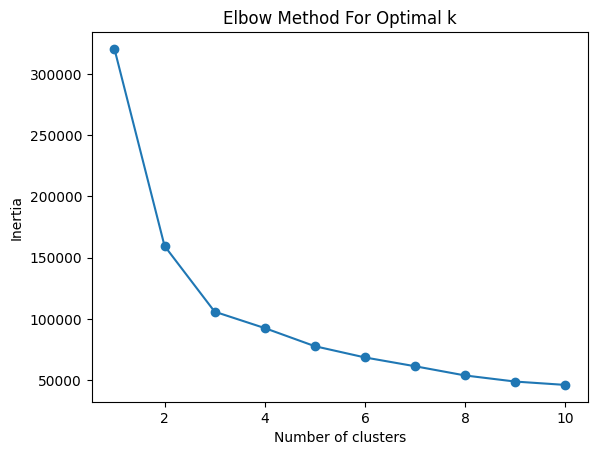

In [12]:
# Determine the optimal number of clusters using the elbow method
inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    inertia.append(km.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


